In [1]:
# Import Libraries and Dataset

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [5]:
print(train.shape)

(26729, 10)


In [6]:
# Null Values

In [7]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [8]:
train.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A671945,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


# Exploratory Data ANalysis

In [9]:
# Extract year, month, day, hour from datetime

In [10]:
train_data = train.copy()
test_data = test.copy()
train['year'] = pd.DatetimeIndex(train.DateTime).year
train['month'] = pd.DatetimeIndex(train.DateTime).month
train['day'] = pd.DatetimeIndex(train.DateTime).day
train['hour'] = pd.DatetimeIndex(train.DateTime).hour
train['dayofweek'] = pd.DatetimeIndex(train.DateTime).dayofweek
train['date'] = pd.DatetimeIndex(train.DateTime).date
train['monthyear'] = pd.DatetimeIndex(train.DateTime).strftime('%Y-%m')
train['IsWeekend'] = (pd.DatetimeIndex(train.DateTime).dayofweek) // 5 == 1

In [11]:
# See all SexuponOutcome options
train.SexuponOutcome = train.SexuponOutcome.astype(str)
train.SexuponOutcome.value_counts()

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
nan                 1
Name: SexuponOutcome, dtype: int64

In [12]:
# Feature Enginnering

In [13]:
# Split Sexupon Outcome to Sex and Alter Type
def is_altered(SexuponOutcome):
    if "unknown" in SexuponOutcome.lower():
        return "Unknown"
    elif "intact" in SexuponOutcome.lower():
        return "Intact"
    else:
        return "Altered"

In [14]:
def gender(SexuponOutcome):
    if "unknown" in SexuponOutcome.lower():
        return "Unknown"
    elif "female" in SexuponOutcome.lower():
        return "Female"
    else:
        return "Male"

In [15]:
train['Is_Altered'] = train.SexuponOutcome.apply(is_altered)
train['Gender'] = train.SexuponOutcome.apply(gender)

In [16]:
# Identify mixed breed vs full breed
def breed_type(breed):
#     if "/" in breed or "mix" in breed.lower():
    if "mix" in breed.lower():
        return "Mixed Breed"
    else:
        return "Full Breed"

In [17]:
train['Breed_Type'] = train.Breed.apply(breed_type)

In [18]:
# Check if pet has a name
def has_name(name):
    if pd.isnull(name):
        return False
    else:
        return True

In [19]:
train['Has_Name'] = train.Name.apply(has_name)

In [20]:
# Extract pet age from string and adjust age if less than 1 years old
def clean_age(x):
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year') > -1: return age 
    if x.find('month')> -1: return age / 12.
    if x.find('week')> -1: return age / 52.
    if x.find('day')> -1: return age / 365.
    else: return 0

In [21]:
train.AgeuponOutcome = train.AgeuponOutcome.astype(str)
train['Age'] = train.AgeuponOutcome.apply(clean_age)

<AxesSubplot:xlabel='Age', ylabel='Density'>

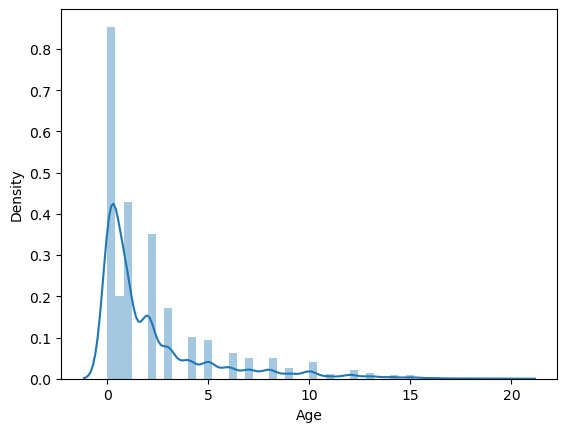

In [22]:
# Distribution of ages
sns.distplot(train.Age)

<AxesSubplot:xlabel='OutcomeType', ylabel='count'>

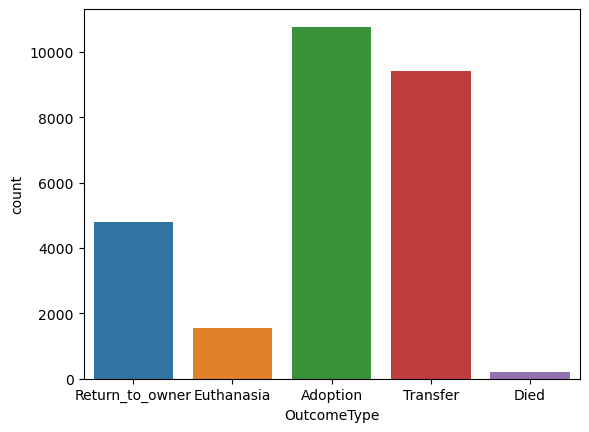

In [23]:
# Distribution of outcome type
sns.countplot(x = train.OutcomeType)

<AxesSubplot:xlabel='Gender', ylabel='count'>

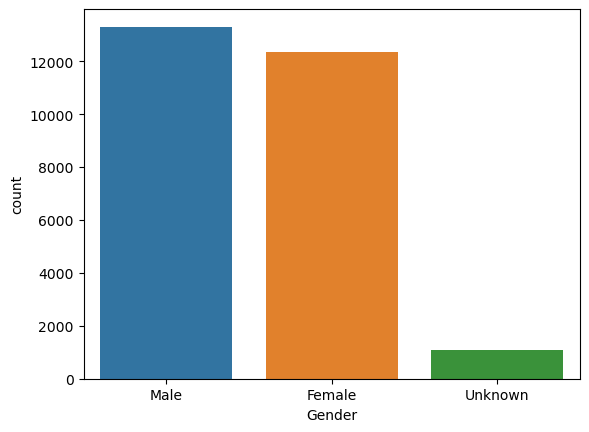

In [24]:
# number of pets by sex
sns.countplot(x="Gender", data = train)

<AxesSubplot:xlabel='Gender', ylabel='count'>

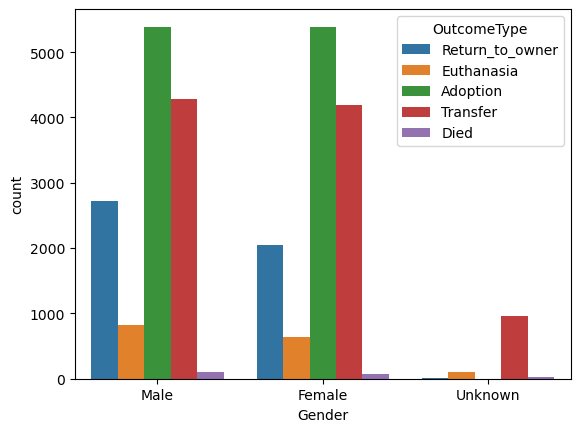

In [25]:
# what are the outcomes by sex
sns.countplot(x="Gender", hue = "OutcomeType", data = train)

<AxesSubplot:xlabel='AnimalType', ylabel='count'>

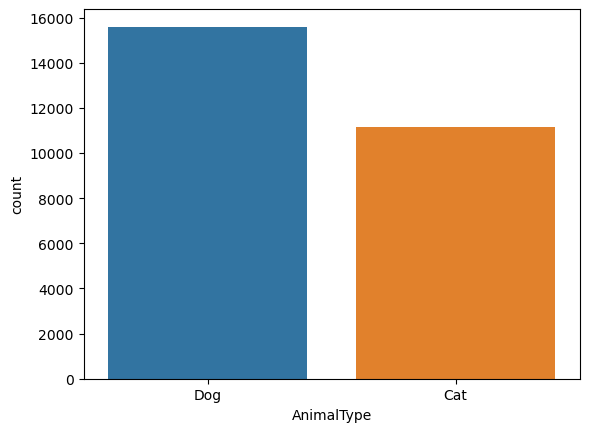

In [26]:
sns.countplot(x="AnimalType", data = train)

In [27]:
# Total outcomes by animal type
train.AnimalType.value_counts()

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

<AxesSubplot:>

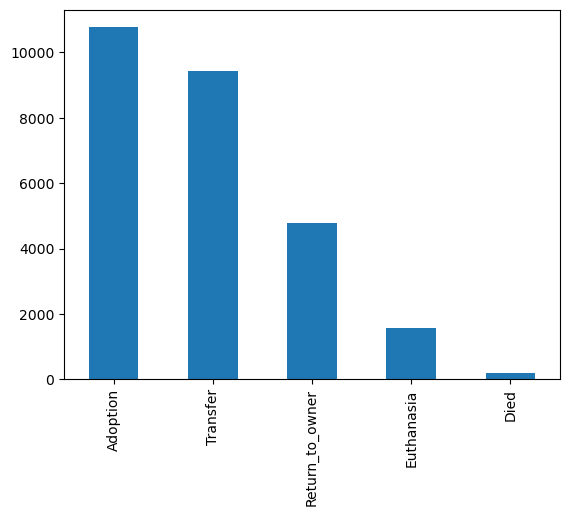

In [28]:
train['OutcomeType'].value_counts().plot.bar()

[Text(0.5, 0, 'Type of Animal'),
 Text(0, 0.5, 'Total Outcomes by Type'),
 Text(0.5, 1.0, 'Outcome by Animal')]

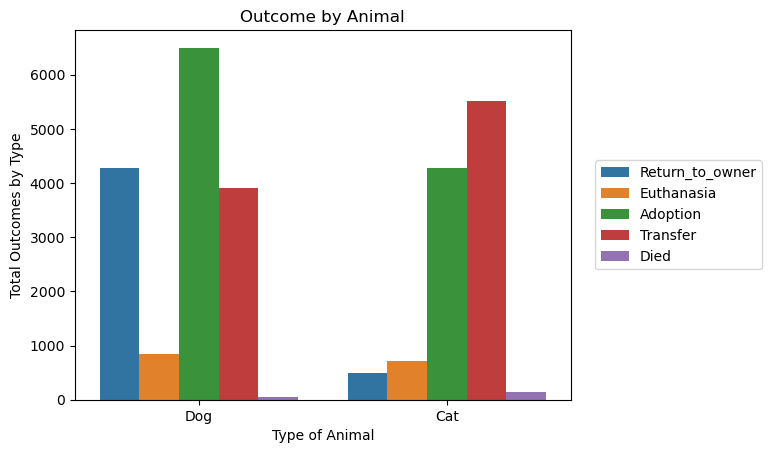

In [29]:
# number of animals by species
ax = sns.countplot(x="AnimalType", hue = "OutcomeType", data = train)
ax.legend(loc = 5, bbox_to_anchor=(1.4, 0.5))
ax.set(xlabel = "Type of Animal",
       ylabel = "Total Outcomes by Type",
       title = "Outcome by Animal")

<AxesSubplot:xlabel='Is_Altered', ylabel='count'>

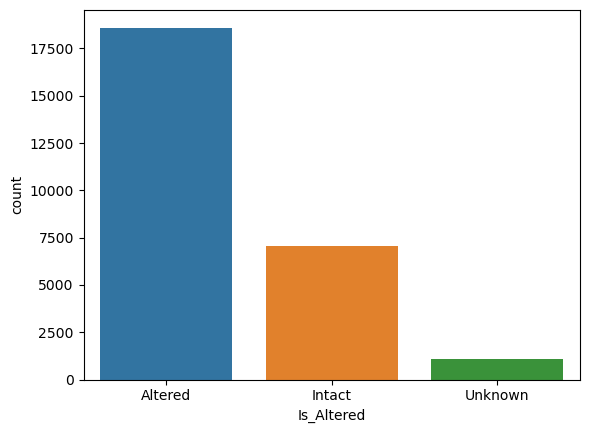

In [30]:
sns.countplot(x="Is_Altered", data = train)

<AxesSubplot:xlabel='Is_Altered', ylabel='count'>

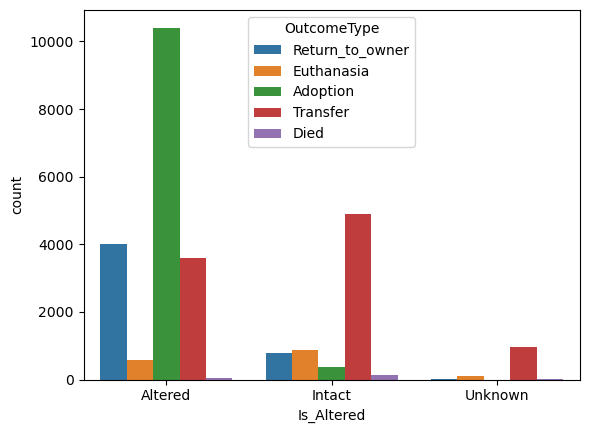

In [31]:
sns.countplot(x="Is_Altered", hue = "OutcomeType", data = train)

<AxesSubplot:xlabel='Breed_Type', ylabel='count'>

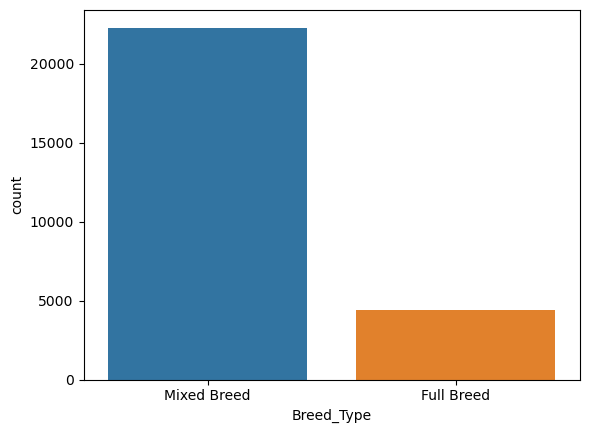

In [32]:
sns.countplot(x="Breed_Type", data = train)

<AxesSubplot:xlabel='Breed_Type', ylabel='count'>

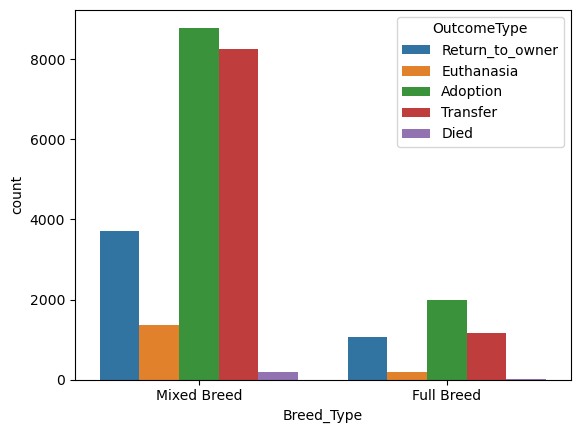

In [33]:
sns.countplot(x="Breed_Type", hue = "OutcomeType",data = train)

<AxesSubplot:xlabel='Has_Name', ylabel='count'>

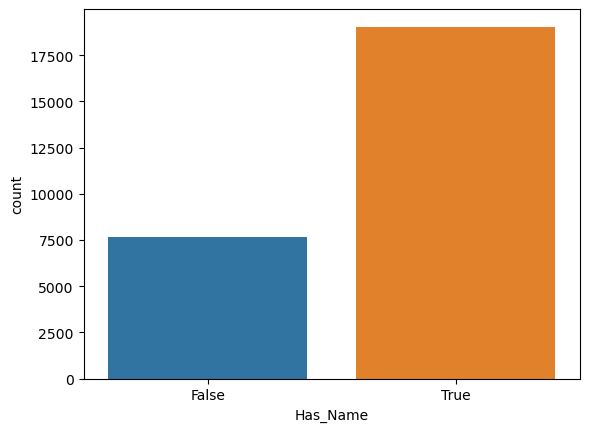

In [34]:
sns.countplot(x="Has_Name", data = train)

<AxesSubplot:xlabel='OutcomeType', ylabel='Age'>

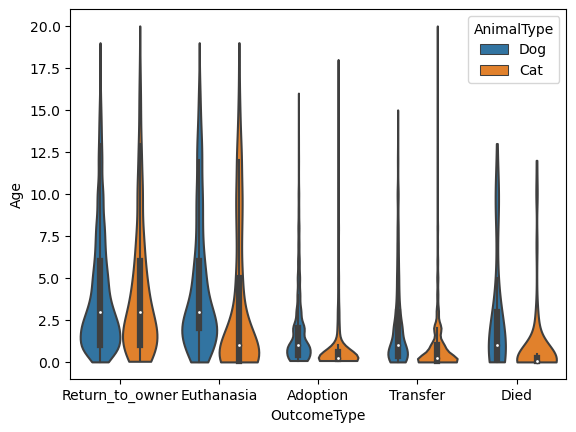

In [35]:
sns.violinplot(x = "OutcomeType", y = "Age", hue = "AnimalType", data = train, cut = 0, split = False)

<AxesSubplot:xlabel='Has_Name', ylabel='count'>

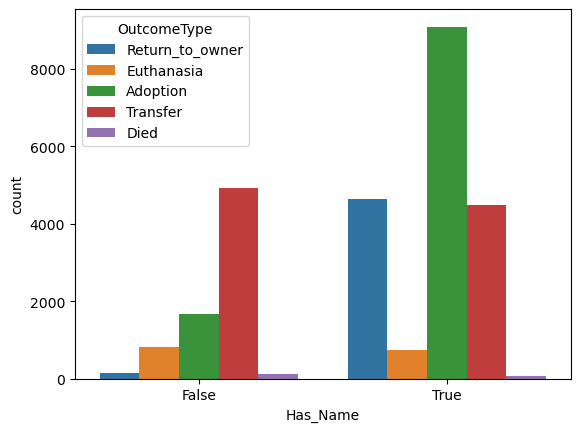

In [36]:
sns.countplot(x="Has_Name", hue = "OutcomeType", data = train)

<AxesSubplot:xlabel='hour', ylabel='count'>

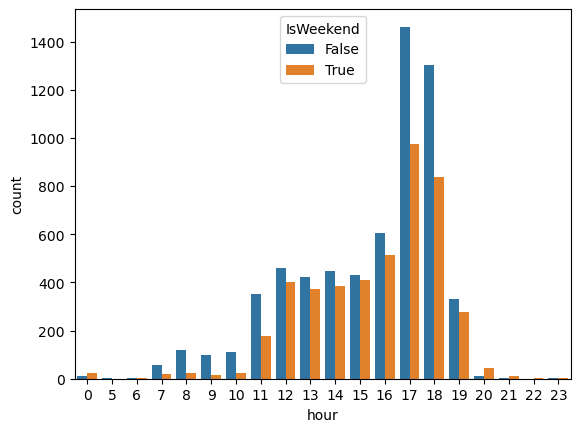

In [37]:
sns.countplot(x="hour", hue = 'IsWeekend', data = train[train.OutcomeType == 'Adoption'])

<AxesSubplot:xlabel='month', ylabel='count'>

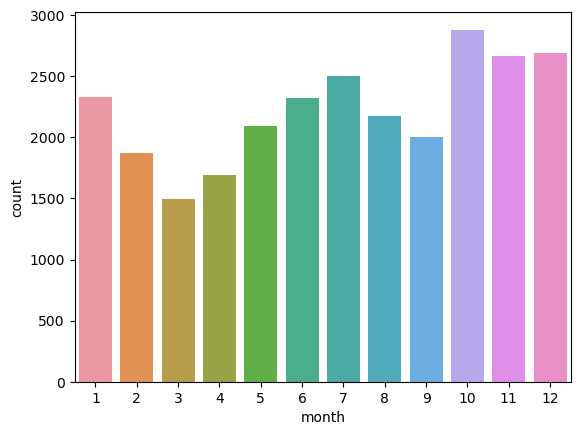

In [38]:
sns.countplot(x="month", data = train) # 2013 only has 3 months of data

In [39]:
# Create subset to show adoptions by animal type and month
adoptionTrain = train[(train.OutcomeType == "Adoption")
                        & (train.year != 2013)
                       ].groupby(by = ["AnimalType", "month"], as_index = False).count()

<AxesSubplot:xlabel='month', ylabel='AnimalID'>

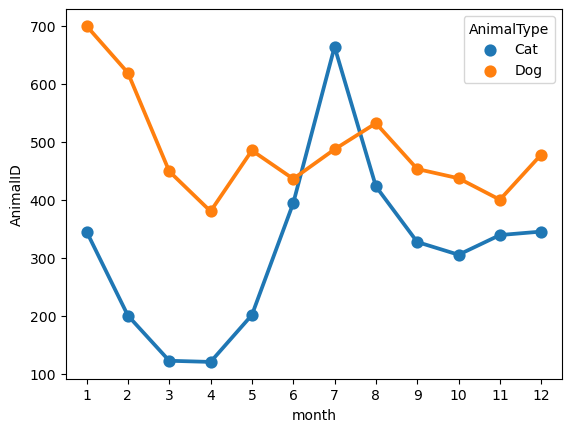

In [40]:
sns.pointplot(x = "month", y = "AnimalID", data = adoptionTrain, hue = "AnimalType")

# Data Cleaning and Preparation for modeling

In [41]:
test_ID = test_data['ID']
train_OutcomeType = train_data['OutcomeType']
train_df = train_data.drop(['AnimalID','OutcomeSubtype','OutcomeType'] , axis=1)
test_df = test_data.drop('ID', axis=1)

combine_df = pd.concat([train_df, test_df], axis=0)

In [42]:
# Name
combine_df['HasName']=combine_df['Name'].notnull().astype(int)

In [43]:
# DateTime
interval = pd.to_datetime(combine_df['DateTime'])-pd.to_datetime('2013-01-01')
combine_df['DateTime_day'] = interval /np.timedelta64(1, 'D')
interval = ((interval/np.timedelta64(1, 'D'))%1*24)
interval[(interval>=0) & (interval)<6] = 0 #'midnight'
interval[(interval>=6) & (interval<12)] = 1 #'morning'
interval[(interval>=12) & (interval<18)] = 2 #'afternoon'
interval[(interval>=18) & (interval<22)] = 3 #'evening'
interval[(interval>=22) & (interval<24)] =0 # 'midnight'
combine_df['DateTime_mmae'] = interval

In [44]:
# AnimalType
combine_df['AnimalType'] = combine_df['AnimalType'].map({'Dog':0, 'Cat':1})

In [45]:
# SexuponOutcome
combine_df['SexuponOutcome'] = combine_df['SexuponOutcome'].fillna(combine_df['SexuponOutcome'].mode()[0])
combine_df['Sex'] = combine_df['SexuponOutcome'].map({'Intact Female':0,'Spayed Female':0,'Intact Male':1,'Neutered Male':1,'Unknown':2})
combine_df['IsIntact'] = combine_df['SexuponOutcome'].map({'Intact Female':0,'Intact Male':0, 'Neutered Male':1,'Spayed Female':1,'Unknown':2})
combine_df[['SexuponOutcome','Sex','IsIntact']].head()

,SexuponOutcome,Sex,IsIntact
0,Neutered Male,1,1
1,Spayed Female,0,1
2,Neutered Male,1,1
3,Intact Male,1,0
4,Neutered Male,1,1


In [46]:
# AgeuponOutcome
combine_df['AgeuponOutcome'] = combine_df['AgeuponOutcome'].fillna(combine_df['AgeuponOutcome'].mode()[0])
def convert(x):
    a = str(x).split(' ')[0]
    b = str(x).split(' ')[-1]
    if 'year' in str(b):
        return int(a)*12*52*7
    elif 'month' in str(b):
        return int(a)*4*7
    elif 'week' in str(b):
        return int(a)*7
    else:
        return int(a)

combine_df['AgeuponOutcome'] = combine_df['AgeuponOutcome'].map(convert)

In [47]:
#Breed
combine_df['IsMix'] = combine_df['Breed'].map(lambda x: 'Mix' in x).astype(int)
combine_df['Breed'] = combine_df['Breed'].map(lambda x:x.strip(' Mix').split('/')[0].split(' ')[-1])

In [48]:
# Color 
combine_df['IsPure'] = combine_df['Color'].map(lambda x: '/' not in x).astype(int)
combine_df[['Color','IsPure']].head()
combine_df['Color'] = combine_df['Color'].map(lambda x: x.split('/')[0].split(' ')[0])

In [49]:
combine_df_DateTime_mmae = pd.get_dummies(combine_df['DateTime_mmae'], prefix='DateTime_mmae')
combine_df_breed = pd.get_dummies(combine_df['Breed'], prefix='Breed')
combine_df_color = pd.get_dummies(combine_df['Color'], prefix='Color')
combine_df['DateTime_day'] = (combine_df['DateTime_day'] - combine_df['DateTime_day'].min())/(combine_df['DateTime_day'].max() - combine_df['DateTime_day'].min())
combine_df['AgeuponOutcome'] = (combine_df['AgeuponOutcome'] - combine_df['AgeuponOutcome'].min())/(combine_df['AgeuponOutcome'].max() - combine_df['AgeuponOutcome'].min())

In [50]:
# Train test splt

In [51]:
X = combine_df[['HasName','AnimalType', 'AgeuponOutcome','Sex','IsIntact','IsMix','IsPure']]
X = pd.concat([X, combine_df_breed, combine_df_color, combine_df_DateTime_mmae], axis=1)
train_x = X.iloc[0:train_df.shape[0],]
test_x = X.iloc[train_df.shape[0]:,]
train_y = train_OutcomeType.map({'Adoption':0,'Died':1,'Euthanasia':2,'Return_to_owner':3,'Transfer':4})

In [52]:
names = train_x.columns.values
train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
print(train_x.shape, test_x.shape)

(26729, 184) (11456, 184)


# Feature Importance

In [53]:
rf = RandomForestRegressor()
r = rf.fit(train_x, train_y)
vals = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)
df_results = pd.DataFrame(vals, columns=['Feature Score',"Column_name"])
df_results

,Feature Score,Column_name
0,0.30,IsIntact
1,0.20,AgeuponOutcome
2,0.07,Sex
3,0.04,IsPure
4,0.03,IsMix
...,...,...
179,0.00,Breed_Burmese
180,0.00,Breed_Brown
181,0.00,Breed_Brindle
182,0.00,Breed_Bordeaux


# Modelling

In [54]:
#lazy predict
tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y,test_size=0.3,random_state=0)
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)
models,predictions = clf.fit(tr_x, va_x, tr_y, va_y)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [07:09<00:00, 14.81s/it]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.35,0.42,None,0.38,0.23
XGBClassifier,0.65,0.41,None,0.63,13.03
LGBMClassifier,0.65,0.41,None,0.63,1.03
AdaBoostClassifier,0.62,0.40,None,0.61,4.64
RandomForestClassifier,0.61,0.39,None,0.60,4.03
BaggingClassifier,0.60,0.39,None,0.59,1.96
ExtraTreesClassifier,0.60,0.39,None,0.59,5.32
DecisionTreeClassifier,0.58,0.38,None,0.58,0.43
BernoulliNB,0.59,0.38,None,0.58,0.33


In [55]:
# XGBoost Classifier

In [56]:
xgbc = XGBClassifier()
xgbc.fit(tr_x, tr_y)

va_pred = xgbc.predict_proba(va_x)
ll = log_loss(va_y, va_pred)
print("Log Loss: {:.4f}".format(ll))

Log Loss: 0.8430


In [57]:
# Deep learning approach

In [58]:
from tensorflow import keras 
import tensorflow as tf
import kerastuner as kt

In [59]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  # Initialize the Sequential API and start stacking the layers
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(184,)))
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_1'))
  # Add next layers
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(units=hp_units, activation='relu', name='dense_2'))  
  model.add(keras.layers.Dense(5, activation='softmax', name='dense_3'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model

In [60]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='dir', # directory to save logs 
project_name='AnimalML')

In [61]:
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [62]:
tuner.search(tr_x, tr_y, epochs=50, validation_data=(va_x, va_y))

Trial 30 Complete [00h 00m 16s]
val_accuracy: 0.6286320090293884

Best val_accuracy So Far: 0.6440953016281128
Total elapsed time: 00h 05m 30s
INFO:tensorflow:Oracle triggered exit


In [63]:
best_hp=tuner.get_best_hyperparameters()[0]
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()
h_model.fit(tr_x, tr_y, epochs=75, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 184)               0         
                                                                 
 dense_1 (Dense)             (None, 448)               82880     
                                                                 
 dropout_1 (Dropout)         (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 448)               201152    
                                                                 
 dense_3 (Dense)             (None, 5)                 2245      
                                                                 
Total params: 286,277
Trainable params: 286,277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
468/468 [============================

Epoch 51/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5652 - accuracy: 0.7617 - val_loss: 1.4784 - val_accuracy: 0.5951
Epoch 52/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5645 - accuracy: 0.7611 - val_loss: 1.4884 - val_accuracy: 0.6002
Epoch 53/75
468/468 [==============================] - 3s 5ms/step - loss: 0.5582 - accuracy: 0.7632 - val_loss: 1.5158 - val_accuracy: 0.5951
Epoch 54/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5541 - accuracy: 0.7712 - val_loss: 1.4987 - val_accuracy: 0.5906
Epoch 55/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5554 - accuracy: 0.7657 - val_loss: 1.5396 - val_accuracy: 0.5925
Epoch 56/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5558 - accuracy: 0.7666 - val_loss: 1.5101 - val_accuracy: 0.5919
Epoch 57/75
468/468 [==============================] - 2s 5ms/step - loss: 0.5560 - accuracy: 0.7660 - val_loss: 1.5435 - val_accuracy: 0.5911